# Bayesian Linear Models in `numpyro`

Quite possibly the simplest possible example of `numpyro` ever.

From: [Persuasive Python: Bayesian Linear Models](https://www.persuasivepython.com/10-linpred)

Imagine a most basic example in which we want to estimate the sales price (in \$K) of a home given the square footage of the home.

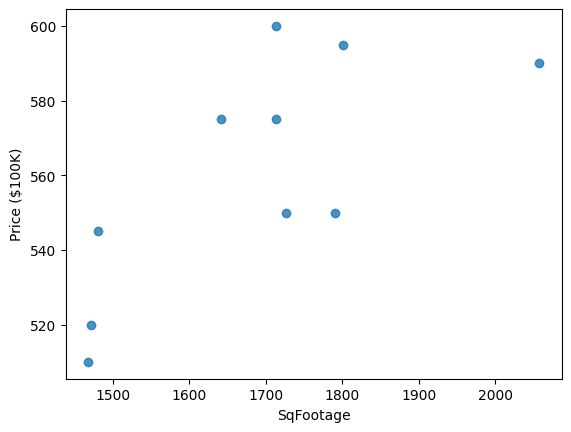

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
## make two data arrays representing observations
## of home sales

salesPrice = [590, 575, 550, 520, 545, 
              575, 550, 510, 595, 600]
sqFootage = [2057, 1713, 1791, 1472, 1481, 
             1642, 1727, 1468, 1801, 1713]
numBed = [3, 4, 4, 3, 3, 4, 4, 3, 4, 4]

plt.scatter(sqFootage, salesPrice, alpha=0.8)
plt.xlabel("SqFootage")
plt.ylabel("Price ($100K)");

We can use polyfit to get the coefficients via OLS:

In [2]:
np.polyfit(np.array(sqFootage), np.array(salesPrice), deg=1, )

array([1.22556924e-01, 3.54307747e+02])

The model:

$$
\begin{aligned}
y &\sim N(\mu, \sigma) \\
\mu_i &= \alpha + \beta x_i
\end{aligned}
$$

where:

$$
\begin{aligned}
x_i &= \text{The value of an explanatory variable for the } i^{th} \text{ observation}\\
\alpha &= \text{Intercept}\\
\beta &= \text{Coefficients}\\
\mu_i &= \text{Expected value for the } i^{th} \text{ observation}
\end{aligned}
$$

With the specific example, $x$ is the square footage and $\beta$ will represent the expected price per sq foot. 

In [3]:
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
from numpyro.diagnostics import hpdi

## Convert observed data to arrays - numpyro will NOT accept a pandas series as input
salesPriceData = jnp.array(salesPrice)
sqFootageData = jnp.array(sqFootage)

# 1. Spec Model
def salesPriceModel(salesPriceArray, sqFootageArray):
    """
	In numpyro, we specify the model as a python function
	"""
    beta = numpyro.sample('beta', dist.Normal(0.275, 0.8))
    sigma = numpyro.sample('sigma', dist.HalfCauchy(1))
    mu = numpyro.deterministic('mu', beta * sqFootageArray)
    y = numpyro.sample('y', dist.Normal(mu, sigma), obs=salesPriceArray)
    return y

# 2. Run Inference engine to get posterior 
nuts_kernel = NUTS(salesPriceModel)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000) 
# jax needs a rng key
rng_key = random.PRNGKey(seed = 42)
# running with the observations
mcmc.run(rng_key, salesPriceArray=salesPriceData, 
         sqFootageArray=sqFootageData)
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2932.62it/s, 7 steps of size 5.80e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.33      0.01      0.33      0.32      0.34   1127.94      1.00
     sigma     45.30     11.58     43.53     28.37     60.66   1152.12      1.00

Number of divergences: 0


In [4]:
az.summary(mcmc)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.330,0.009,0.316,0.348,0.000,0.000,1171.0,973.0,NaN
mu[0],679.723,17.494,650.096,715.486,0.522,0.369,1171.0,973.0,NaN
mu[1],566.051,14.569,541.378,595.832,0.435,0.308,1171.0,973.0,NaN
mu[2],591.825,15.232,566.029,622.963,0.455,0.322,1171.0,973.0,NaN
mu[3],486.414,12.519,465.212,512.005,0.374,0.264,1171.0,973.0,NaN
mu[4],489.388,12.595,468.057,515.136,0.376,0.266,1171.0,973.0,NaN
mu[5],542.589,13.965,518.939,571.136,0.417,0.295,1171.0,973.0,NaN
mu[6],570.677,14.688,545.803,600.702,0.438,0.310,1171.0,973.0,NaN
mu[7],485.092,12.485,463.948,510.614,0.373,0.264,1171.0,973.0,NaN
mu[8],595.130,15.317,569.190,626.441,0.457,0.323,1171.0,973.0,NaN


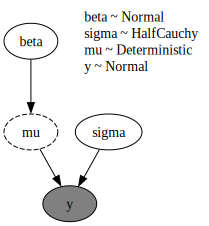

In [5]:
# Render model with graphviz
numpyro.render_model(salesPriceModel, 
                     model_args=(salesPriceData, sqFootageData),
                     render_params=True,
                     render_distributions=True)

In [6]:
# Prior Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(salesPriceModel, num_samples=100)
prior_predictions = prior_predictive(rng_key_, salesPriceData, sqFootageData)['mu']

mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

mean_prior_pred

Array([414.2696 , 344.98975, 360.69855, 296.45352, 298.26608, 330.6907 ,
       347.8093 , 295.64792, 362.7125 , 344.98975], dtype=float32)

In [7]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      0.33      0.01      0.33      0.32      0.34   1127.94      1.00
     sigma     45.30     11.58     43.53     28.37     60.66   1152.12      1.00

Number of divergences: 0


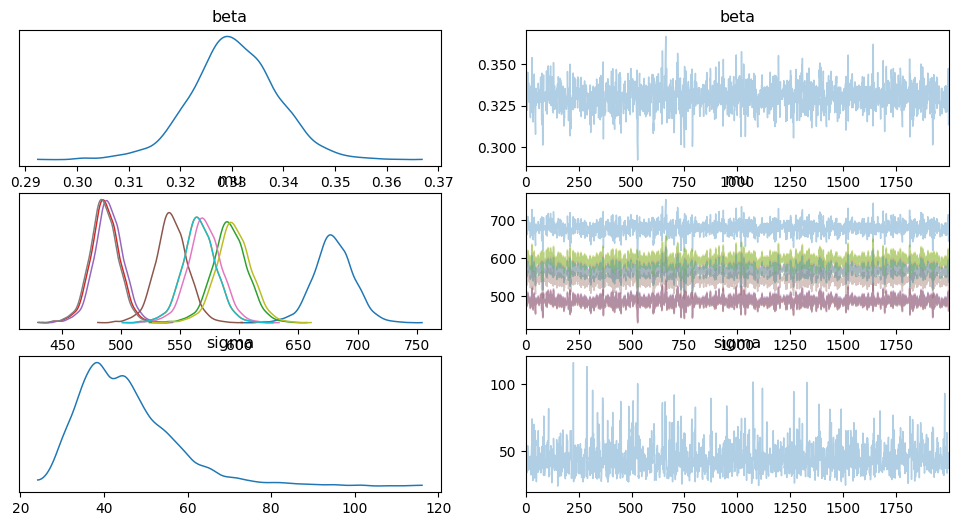

In [8]:
# useful plot
az.plot_trace(mcmc, compact=True);

<Axes: title={'center': 'beta'}>

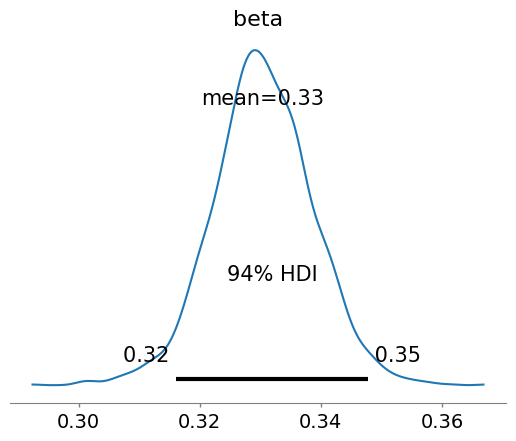

In [9]:
# Analyzing posterior distribution
az.plot_posterior(mcmc, var_names=['beta'])

<Axes: title={'center': 'beta'}>

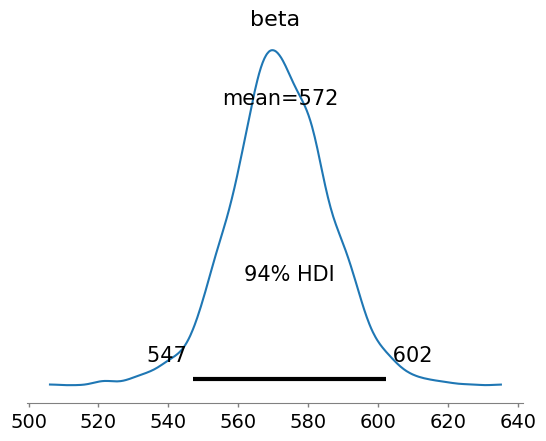

In [10]:
# Get xarray data out
data = az.from_numpyro(mcmc)

# Then our expected revenue would be:
az.plot_posterior(data.posterior['beta'] * 1731)

# Prediction

## Posterior Predictive

The `Predictive` utility runs the model by substituting the latent parameters with samples from the posterior to generate predictions

In [11]:
## get representative sample of posterior
posterior_samples = mcmc.get_samples()

# marginal aka posterior predictive
predictive = Predictive(salesPriceModel, posterior_samples=posterior_samples)
forecast_marginal = predictive(random.PRNGKey(1), salesPriceArray = salesPriceData, sqFootageArray = sqFootageData)

In [12]:
# get the mean values for mu

mean_mu = jnp.mean(forecast_marginal['mu'], axis=0)
# Get the upper and lower bounds of mu
hpdi_mu = hpdi(forecast_marginal['mu']) # shape (2, 10)

In [13]:
def plot_regression(x, y_mean, y_hpdi):
    # n = len(x)
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    exog = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    endog = salesPriceData[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(exog, mean)
    ax.plot(exog, endog, "o")
    ax.fill_between(exog, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

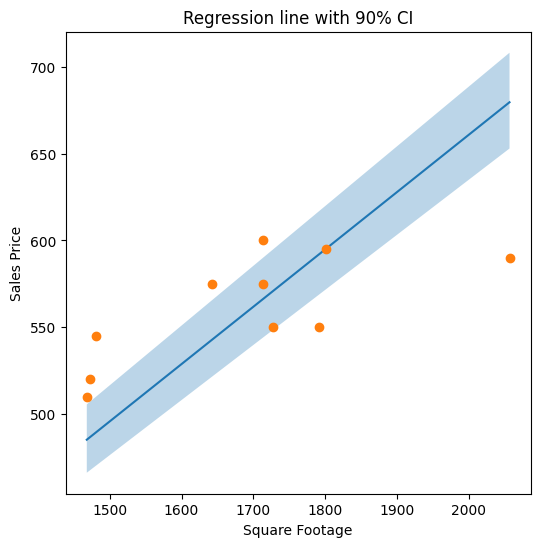

In [14]:
ax = plot_regression(sqFootageData, mean_mu, hpdi_mu)
ax.set(
    xlabel="Square Footage", ylabel="Sales Price", title="Regression line with 90% CI"
);